In [9]:
from stable_baselines3.common.callbacks import BaseCallback
from env import SmartClimateControlEnv
from stable_baselines3 import SAC
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
mean_reward_steps = 9999
TIMESTEPS = mean_reward_steps + 1


# models_dir = f'models/DQN'
models_dir = f'models/SAC'
logdir = 'logs'

for path in [models_dir, logdir]:
    os.makedirs(path, exist_ok=True)

In [ ]:
env = SmartClimateControlEnv()
env.reset()

# model = DQN('MlpPolicy', env, verbose=2, tensorboard_log=logdir, device='cuda')
model = SAC('MlpPolicy', env, verbose=2, tensorboard_log=logdir, device='cuda')


class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)
        self.rewards = []
        

    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        
        if len(self.rewards) % mean_reward_steps == 0: 
            mean_reward = np.mean(self.rewards)
            total_reward = np.sum(self.rewards)
                
            with open('Reward_Log.txt', 'a') as f:
                f.write(f'total reward: {total_reward} - mean reward: {mean_reward}\n')
            
            self.rewards.clear()
            
        return True

In [ ]:
for i in range(1, 101):
    # model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name='DQN', callback=RewardLoggerCallback())
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name='SAC', callback=RewardLoggerCallback())
    model.save(f"{models_dir}/{TIMESTEPS * i}")


---

## Load and use

In [5]:
model_path = 'models/SAC/100'


env = env = SmartClimateControlEnv()
env.reset()


model = SAC.load(model_path, env=env, custom_objects={'observation_space': env.observation_space, 'action_space': env.action_space})

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
# Initialize variables

# Action space: [heater_power, humidifier_power, fan_power]
# Observation space: [temperature, humidity, target_temperature, target_humidity]
total_reward = 0
heater_pwr, humidifier_pwr, fan_pwr = [], [], []
temp, hum, target_temp, target_hum, reward =  [], [], [], [], []


# Reset the environment and get the initial observation
obs, _ = env.reset()
srart_temp, start_hum = obs[0], obs[1]
terminated = False

# Main loop to collect data until termination
while not terminated:
    # Store relevant observations
    temp.append(obs[0])
    hum.append(obs[1])
    target_temp.append(obs[2])
    target_hum.append(obs[3])

    # Predict action based on current observation
    action, _ = model.predict(obs)
    
    # Store action
    heater_pwr.append(action[0])
    humidifier_pwr.append(action[1])
    fan_pwr.append(action[2])
    
    # Take action in the environment and receive feedback
    obs, rwd, terminated, truncated, _ = env.step(action)
    reward.append(rwd)  # Store reward
    total_reward += rwd  # Accumulate total reward


print(f'Total Reward: {total_reward}')

Total Reward: -63.862178802490234


Total Reward: -63.86
Starting Temprature: 19.91



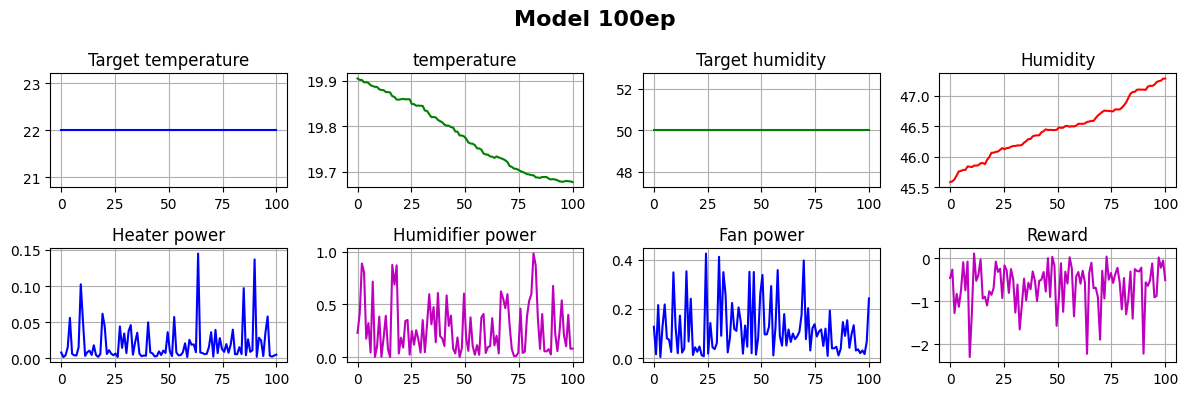

In [25]:
# Plotting the results
title = 'Model 100ep'
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
fig.suptitle(title, fontsize=16, fontweight='bold')

# Define x-axis values for plotting
x = np.linspace(0, len(reward), len(reward))

# Plot each metric in a subplot
axs[0, 0].plot(x, target_temp, 'b')  # Target temperature
axs[0, 0].set_title('Target temperature')
axs[0, 0].grid()

axs[0, 1].plot(x, temp, 'g')  # temperature
axs[0, 1].set_title('temperature')
axs[0, 1].grid()

axs[0, 2].plot(x, target_hum, 'g')  # Target humidity
axs[0, 2].set_title('Target humidity')
axs[0, 2].grid()

axs[0, 3].plot(x, hum, 'r')  # humidity
axs[0, 3].set_title('Humidity')
axs[0, 3].grid()


axs[1, 0].plot(x, heater_pwr, 'b')  # Heater power
axs[1, 0].set_title('Heater power')
axs[1, 0].grid()

axs[1, 1].plot(x, humidifier_pwr, 'm')  # Humidifier power
axs[1, 1].set_title('Humidifier power')
axs[1, 1].grid()

axs[1, 2].plot(x, fan_pwr, 'b')  # Fan power
axs[1, 2].set_title('Fan power')
axs[1, 2].grid()

axs[1, 3].plot(x, reward, 'm')  # Reward
axs[1, 3].set_title('Reward')
axs[1, 3].grid()


# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'{title}.png', dpi=300, bbox_inches='tight')

# Display total reward and final observations
print(f'Total Reward: {total_reward:.2f}')
print(f'Starting Temprature: {srart_temp:.2f}\n')
plt.show()